## Exercise 3

Destination length = 3 ( changes nor required)

In [2]:
#Importing the library pandas

import pandas as pd

In [24]:
#First look at the file (20 rows)

file = pd.read_csv("searches.csv.bz2", compression='bz2', nrows = 100000, sep = '^')

file_head20 =file.head(20)

fileinfo = file.info()

filecolumns = file.columns

print(file_head20)
print(fileinfo)
print(filecolumns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Date               100000 non-null  object
 1   Time               100000 non-null  object
 2   TxnCode            100000 non-null  object
 3   OfficeID           100000 non-null  object
 4   Country            99985 non-null   object
 5   Origin             100000 non-null  object
 6   Destination        100000 non-null  object
 7   RoundTrip          100000 non-null  int64 
 8   NbSegments         100000 non-null  int64 
 9   Seg1Departure      100000 non-null  object
 10  Seg1Arrival        100000 non-null  object
 11  Seg1Date           99605 non-null   object
 12  Seg1Carrier        37841 non-null   object
 13  Seg1BookingCode    10777 non-null   object
 14  Seg2Departure      72141 non-null   object
 15  Seg2Arrival        72141 non-null   object
 16  Seg2Date           71

## Check if there are repeated values

In [59]:
cols = ['Date','Time', 'Origin', 'Destination'] # columns I need to solve the exercise

filter_list = ['MAD', 'BCN', 'AGP'] # Destination airports I need to solve the exercise

file = pd.read_csv("searches.csv.bz2", compression='bz2', nrows = 100000, sep = '^', usecols = cols) # Import file with ony the needed columns

file['Date'] = pd.to_datetime(file['Date'], format='%Y-%m-%d') # turn Datetime column format into datetime format

file['Year'] = 

file = file[file.Destination.isin(filter_list)] # filter the file with only the needed destination airports

file['counter'] = 1 # Add a column with the value '1' to sum up by grouping

grouped_file = file.groupby(['Date','Destination'])['counter'].sum().reset_index() # Sort searches to help to identify potential repeated rows

grouped_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         300 non-null    datetime64[ns]
 1   Destination  300 non-null    object        
 2   counter      300 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 7.2+ KB


In the first 100K rows there are not repeated values so I will consider there are not repeated rows in the dataset

## Split Date by Year and month

#### Setting filters

In [106]:
cols = ['Date','Time','Destination'] # columns I need to solve the exercise

filter_list = ['MAD', 'BCN', 'AGP'] # Destination airports I need to solve the exercise

#### Setting importation

In [119]:
file = pd.read_csv("searches.csv.bz2", compression='bz2', nrows = 100000, sep = '^', usecols = cols) # Import file with ony the needed columns

file = file[file.Destination.isin(filter_list)] # filter the file with only the needed destination airports

#### Checking the possibility of repeated rows

In [120]:
file['counter'] = 1 #adding a counter with the value 1 by line

grouped_file = file.groupby(cols)['counter'].sum().reset_index() # Grouping by date|time|destination to identify potential duplications

grouped_file.sort_values(by = 'counter',ascending = False)

repeated_rows = grouped_file[grouped_file['counter'] > 1] # Identifying potential identical lines

repeated_rows # There are not duplications for the first 100K rows. I will move on assuming this is like that for the rest of the file.

,Date,Time,Destination,counter


In [134]:
# Re-setting the parameters of the importation

cols2 = ['Date','Destination'] # columns I need to solve the exercise

file = pd.read_csv("searches.csv.bz2", compression='bz2', nrows = 100000, sep = '^', usecols = cols2) # Import file with ony the needed columns

file = file[file.Destination.isin(filter_list)] # filter the file with only the needed destination airports

#Re-Grouping and adding up

file['counter'] = 1 #adding a counter with the value 1 by line

grouped_file = file.groupby(cols2)['counter'].sum().reset_index() # Grouping by date|destination 

#### Adding year & month to the aggregated dataset

In [135]:
#Working with dates

grouped_file['Date'] = pd.to_datetime(grouped_file['Date']) # Converting the format of the column Date

grouped_file['year'] = grouped_file['Date'].dt.year # Adding the column year

grouped_file['month'] = grouped_file['Date'].dt.month # Adding the column month

#### Grouping by year and month

In [140]:
grouped_file = grouped_file.groupby(['year','month','Destination'])['counter'].sum().reset_index()

grouped_file = grouped_file.sort_values(by='counter', ascending = False)

grouped_file.head() # Checked out and non NaN in any of the 4 columns

,year,month,Destination,counter
7,2013,3,BCN,536
1,2013,1,BCN,517
4,2013,2,BCN,497
8,2013,3,MAD,433
2,2013,1,MAD,425


#### Preparing the importing process by chunks

In [156]:
# Filters

cols = ['Date','Destination'] 

filter_list = ['MAD', 'BCN', 'AGP']

# Initiating items

df_ini = pd.DataFrame()

n_chunks = 0

rows = 0
    
# Importation

for file in pd.read_csv("searches.csv.bz2", compression='bz2', sep = '^', usecols = cols, chunksize = 1000000):
    
    #Counting rows and chunks 
    
    rows += len(file)
    
    n_chunks += 1
    
    # Filtering

    file = file[file.Destination.isin(filter_list)]

    # Adding a column 'counter'

    file['counter'] = 1

    # First grouping task

    grouped_file = file.groupby(cols)['counter'].sum().reset_index()

    # Wrangling with Date columns

    grouped_file['Date'] = pd.to_datetime(grouped_file['Date'])

    grouped_file['year'] = grouped_file['Date'].dt.year

    grouped_file['month'] = grouped_file['Date'].dt.month

    # Second grouping task

    grouped_file = grouped_file.groupby(['year','month','Destination'])['counter'].sum().reset_index()
    
    # Aggregating chunks to the database
    
    df_ini = df_ini.append(grouped_file)
    
    df_ini = df_ini.groupby(['year','month','Destination'])['counter'].agg('sum').reset_index()
    
    print('Accumulated lines proccesed: ' + str(rows) + ' ( Number of chunks: '+ str(n_chunks) + ')')

Accumulated lines proccesed: 1000000 ( Number of chunks: 1)
Accumulated lines proccesed: 2000000 ( Number of chunks: 2)
Accumulated lines proccesed: 3000000 ( Number of chunks: 3)
Accumulated lines proccesed: 4000000 ( Number of chunks: 4)
Accumulated lines proccesed: 5000000 ( Number of chunks: 5)
Accumulated lines proccesed: 6000000 ( Number of chunks: 6)
Accumulated lines proccesed: 7000000 ( Number of chunks: 7)
Accumulated lines proccesed: 8000000 ( Number of chunks: 8)
Accumulated lines proccesed: 9000000 ( Number of chunks: 9)
Accumulated lines proccesed: 10000000 ( Number of chunks: 10)
Accumulated lines proccesed: 11000000 ( Number of chunks: 11)
Accumulated lines proccesed: 12000000 ( Number of chunks: 12)
Accumulated lines proccesed: 13000000 ( Number of chunks: 13)
Accumulated lines proccesed: 14000000 ( Number of chunks: 14)
Accumulated lines proccesed: 15000000 ( Number of chunks: 15)
Accumulated lines proccesed: 16000000 ( Number of chunks: 16)
Accumulated lines proccese

## Number of lines of the searches file : 20.390.198 rows

#### Checking that the aggregated file makes sense

In [157]:
df_ini # Makes sense ! There are 12 months x 3 airports destinations

,year,month,Destination,counter
0,2013,1,AGP,9633
1,2013,1,BCN,29469
2,2013,1,MAD,24258
3,2013,2,AGP,8379
4,2013,2,BCN,28329
5,2013,2,MAD,22800
6,2013,3,AGP,10659
7,2013,3,BCN,30552
8,2013,3,MAD,24681
9,2013,4,AGP,8265


#### Plotting a graphv( Final solution of the exercise ) 

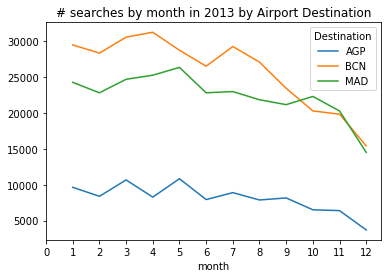

In [180]:
df_pivot = df_ini.pivot(index='month', columns='Destination', values='counter')

df_pivot.plot(title = '# searches by month in 2013 by Airport Destination', xticks =range(0,13));